In [1]:
import json
import numpy as np
import sys
import pickle
import matplotlib.pyplot as plt


NETWORK_FILE_PATH = './cs109_final_backend/cs109_final_backend/network_files/pickled_network.pickle'

with open(NETWORK_FILE_PATH, 'rb') as f: 
    NETWORK = pickle.load(f)

### Create a function that will give n predictions for a given list of songs

This function takes a list of song uris (ie the current playlist) and then returns n=num_top_songs predicted songs in decreasing order of relevance. From each song, it takes num_samples 1-step weighted random walks from the song-node. The samples are then summed and normalized to determine which ones are most important (the ones that are found the most are deemed to be the most important)

In [2]:
def n_top_songs(playlist_songs, network, num_samples=4000, num_top_songs=100): 
    """ Get the n-top song predictions for a given playlist by using the network
    
    Args: 
        playlist_songs: (uri str list) List of spotify track uris; the current playlist
        network : (dict) The network that we build using build_network.py
        num_samples: (int) The number of samples to take from each song in the current playlist
        num_top_songs: (int)
        
    Returns: 
        counted_samples : ((uri (str), prob (float)) tuple list) The n top samples with respective probabilities 
        
    """
    
    key_errors = 0
    all_samples = np.array([])
    for song_uri in playlist_songs: 
        try : 
            sample = np.random.choice(network[song_uri]['songs'], num_samples, p=network[song_uri]['counts'])
            all_samples = np.append(all_samples, sample)
        except KeyError: 
            key_errors += 1
    
    unique, counts = np.unique(all_samples, return_counts=True)
    
    counts = counts.astype(float) / np.sum(counts)
    counted_samples = zip(unique, counts)
    counted_samples = [sample for sample in counted_samples if sample[0] not in playlist_songs]
    counted_samples = sorted(counted_samples, key=lambda x: x[1], reverse=True)
    
    num_to_return = min(num_top_songs, len(counted_samples))

    return counted_samples[:num_to_return]

### Create a function to build the evaluation datasets 

This function reads through playlists that the model has not been trained on, and creates a list of predictor lists (the first n songs in a playlist) and a list of remaining songs (the last total - n songs in the playlist). This is then used to check how many of the remaining songs are in the 500 predicted songs made from the first n songs. 

In [3]:
def build_evaluation_dataset(start, blocks = 1, n_predictors=10, min_remaining = 100, max_remaining = 125) : 
    """ Build a list of first n song lists, and a list of last total - n song lists 
    
    Args: 
        start : (int) the starting playlist slice
        blocks : (int) The number of playlist slices to use
        n_predictor : (int) The number of songs to be in the list of predictor lists
        min_remaining : (int) The minimum number of songs remaining on the playlist
        max_remaining : (int) The maximum number of songs remaining on the playlist
        
    Returns: 
        predictor_songs : ((str list) list) List of predictor song lists
        remainder_songs : ((str list) list) List of remaining songs (the ones we're trying to guess)
    
    """
    f_start = start * 1000
    f_end = start * 1000 + 999
    predictor_songs = []
    remainder_songs = []
    for i in range(blocks): 
        with open('./mpd.v1/data/mpd.slice.{}-{}.json'.format(f_start, f_end)) as f :
            data = json.load(f)
            
            for playlist in data['playlists'] : 
                tracks = [t['track_uri'] for t in playlist['tracks']]
                if len(tracks) >= min_remaining + n_predictors and len(tracks) <= max_remaining + n_predictors: 
                    predict = tracks[:n_predictors]
                    remain = tracks[n_predictors:]

                    predictor_songs.append(predict)
                    remainder_songs.append(remain)
            
            
    return predictor_songs, remainder_songs            

### Create a function to evaluate the accuracy of the predictions

This function takes the first n predictor songs, gets the top predictions, and then evaluates what percent of the remaining songs are in the predicted songs

In [4]:
def evaluate_accuracy(predictors, remaining, network, num_predictions, num_samples=4000): 
    """ Returns the percent of remaining songs that are found in the predictions from the 
        network model 
        
    Args: 
        predictors : ((str list) list) List of predictor song lists
        remaining : ((str list) list) List of the remaining song lists
        network : (dict) The network/model 
        num_predictions : (int) The number of songs that the model should predict
        num_samples : (int) The number of samples to take from each song
        
    Returns: 
        accuracy: (float) Ratio of remaining songs in the predictions over the
                total number of remaining songs
    
    """
    
    preds = n_top_songs(predictors, network, num_top_songs = num_predictions, num_samples=num_samples)
    preds = [p[0] for p in preds]
    accuracy = len([x for x in preds if x in remaining])/(1. * len(remaining))
    
    return accuracy


### Evaluation

Now it's time to start evaluating the model using our above evaluation method. We will stick with predicting songs for playlists with between 100-125 remaining songs (S)so that the number of remaining songs does not impact the accuarcy of the predictions. We will then do this for the number of predictor songs (k) = [1,5,10,25,100]. First we will do this building test sets from the same set of slices, and then we will build distributions of the mean accuracies/medains from different test slices.

#### K = 1, 100 <= S <= 200

In [5]:
# Get the predictors / remainders lists 
predictors, remainders = build_evaluation_dataset(100, blocks=15,n_predictors=1)

# Print out the number of test points we've created
print("We made {} test data points".format(len(predictors)))

# get the accuracies
accuracies = []
for pred, rem in zip(predictors, remainders): 
    accuracies.append(evaluate_accuracy(pred, rem, NETWORK, 500))

# print the stats
print("Mean accuracy: {}".format(np.mean(accuracies)))
print("Variance of accuracy: {}".format(np.var(accuracies)))
print("Median accuracy: {}".format(np.median(accuracies)))

We made 1200 test data points
Mean accuracy: 0.2145462573858684
Variance of accuracy: 0.029833124895706113
Median accuracy: 0.17331532104259378


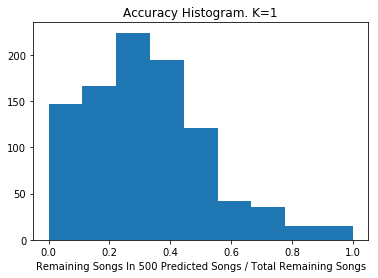

In [17]:
# Plot a histogram of the accuracies
bins = np.linspace(0,1,10)
plt.hist(accuracies, bins=bins)
plt.title('Accuracy Histogram. K=1')
plt.xlabel('Remaining Songs In 500 Predicted Songs / Total Remaining Songs')
plt.show()

#### K = 5, 100 <= S <= 200

In [7]:
# Get the predictors / remainders lists 
predictors, remainders = build_evaluation_dataset(100, blocks=15,n_predictors=5)

# Print out the number of test points we've created
print("We made {} test data points".format(len(predictors)))

# get the accuracies
accuracies = []
for pred, rem in zip(predictors, remainders): 
    accuracies.append(evaluate_accuracy(pred, rem, NETWORK, 500))

# print the stats
print("Mean accuracy: {}".format(np.mean(accuracies)))
print("Variance of accuracy: {}".format(np.var(accuracies)))
print("Median accuracy: {}".format(np.median(accuracies)))

We made 1080 test data points
Mean accuracy: 0.32139562346719674
Variance of accuracy: 0.042477581706787976
Median accuracy: 0.28699677938808377


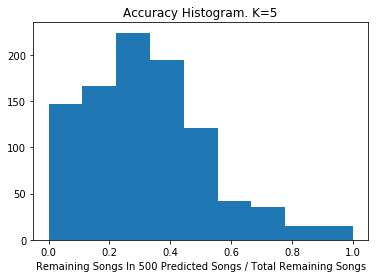

In [14]:
# Plot a histogram of the accuracies
bins = np.linspace(0,1,10)
plt.hist(accuracies, bins=bins)
plt.title('Accuracy Histogram. K=5')
plt.xlabel('Remaining Songs In 500 Predicted Songs / Total Remaining Songs')
plt.show()

#### K = 10, 100 <= S <= 200

In [9]:
# Get the predictors / remainders lists 
predictors, remainders = build_evaluation_dataset(100, blocks=15,n_predictors=10)

# Print out the number of test points we've created
print("We made {} test data points".format(len(predictors)))

# get the accuracies
accuracies = []
for pred, rem in zip(predictors, remainders): 
    accuracies.append(evaluate_accuracy(pred, rem, NETWORK, 500))

# print the stats
print("Mean accuracy: {}".format(np.mean(accuracies)))
print("Variance of accuracy: {}".format(np.var(accuracies)))
print("Median accuracy: {}".format(np.median(accuracies)))

We made 960 test data points
Mean accuracy: 0.3270653288973049
Variance of accuracy: 0.04193042369720653
Median accuracy: 0.2972972972972973


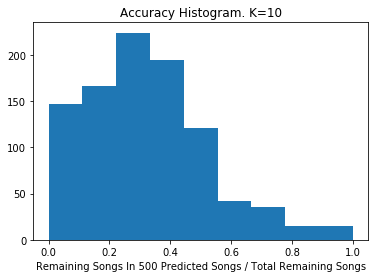

In [13]:
# Plot a histogram of the accuracies
bins = np.linspace(0,1,10)
plt.hist(accuracies, bins=bins)
plt.title('Accuracy Histogram. K=10')
plt.xlabel('Remaining Songs In 500 Predicted Songs / Total Remaining Songs')
plt.show()

#### K = 25, 100 <= S <= 200

In [19]:
# Get the predictors / remainders lists 
predictors, remainders = build_evaluation_dataset(100, blocks=20,n_predictors=25)

# Print out the number of test points we've created
print("We made {} test data points".format(len(predictors)))

# get the accuracies
accuracies = []
for pred, rem in zip(predictors, remainders): 
    accuracies.append(evaluate_accuracy(pred, rem, NETWORK, 500))

# print the stats
print("Mean accuracy: {}".format(np.mean(accuracies)))
print("Variance of accuracy: {}".format(np.var(accuracies)))
print("Median accuracy: {}".format(np.median(accuracies)))

We made 900 test data points
Mean accuracy: 0.3542122164714783
Variance of accuracy: 0.05373157697088638
Median accuracy: 0.27884615384615385


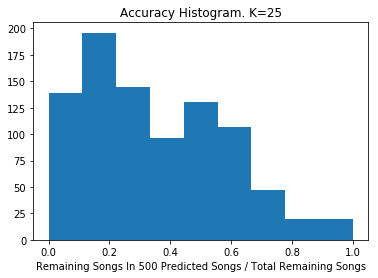

In [20]:
# Plot a histogram of the accuracies
bins = np.linspace(0,1,10)
plt.hist(accuracies, bins=bins)
plt.title('Accuracy Histogram. K=25')
plt.xlabel('Remaining Songs In 500 Predicted Songs / Total Remaining Songs')
plt.show()

#### K = 100, 100 <= S <= 200

In [7]:
# Get the predictors / remainders lists 
predictors, remainders = build_evaluation_dataset(100, blocks=30,n_predictors=100)

# Print out the number of test points we've created
print("We made {} test data points".format(len(predictors)))

# get the accuracies
accuracies = []
for pred, rem in zip(predictors, remainders): 
    accuracies.append(evaluate_accuracy(pred, rem, NETWORK, 500, num_samples=800))

# print the stats
print("Mean accuracy: {}".format(np.mean(accuracies)))
print("Variance of accuracy: {}".format(np.var(accuracies)))
print("Median accuracy: {}".format(np.median(accuracies)))

We made 840 test data points
Mean accuracy: 0.24453053897683252
Variance of accuracy: 0.02600706346989056
Median accuracy: 0.23585404547858274


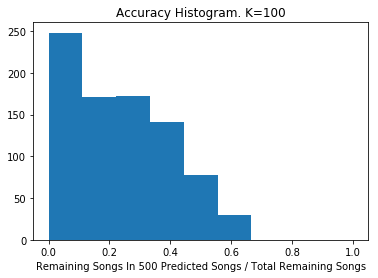

In [8]:
# Plot a histogram of the accuracies
bins = np.linspace(0,1,10)
plt.hist(accuracies, bins=bins)
plt.title('Accuracy Histogram. K=100')
plt.xlabel('Remaining Songs In 500 Predicted Songs / Total Remaining Songs')
plt.show()